# Sina's Wieners
### A Discrete Time Simulation

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from modsim import *
import pandas as pd
from datetime import date, timedelta
from scipy import stats

plt.style.use('dark_background')

### Generate 10k Customers

Attributes:

* Salary
* Cash
* Credit
* Affinity
* Seasonality
* Willingness

The amount of money each is given will be based on an estimated average/mean salary for 2020.  We do not have complete information from later years.  The mean was \$53,383, and the median \$34,612.  Theoretically, half of the people should have a salary below the median, and the median and mean should line up.  In reality, this figure is highly skewed:

!["Source: https://www.ssa.gov/OACT/COLA/central.html"](wages.png)

Over time, the pay of management has risen far faster than the pay of "regular" employees.  So, for this experiment, we will assume that the hyper rich don't care for hotdogs, and that the median salary is the most realistic for the most people.  Median household salary for 2020 was around \$67,000 according to the US Census, and the poverty line for a 3-person household was \$21,700 according to the department of Health and Human Services.

For simplicity, we will assume salaries for individual customers of Sina's Wieners to be normally distributed, centered around \$35,000, with a standard deviation of \$14,000.  We know that reality is much messier than this, but we have to start somewhere.


In [2]:
salary_mean = 53383
salary_median = 34612
poverty_line = 21700
p = 0.114
q = 1 - p


Cash and credit will initialize at zero.

The affinity score will range from 0 to 1, again normally distributed around the center of the range.

Seasonality will determine the likelihood that an individual's willingness to go outside is affected by the weather.  We will generate this information on an exponential curve with lambda equal to 10. A score closer to zero will mean you don't care how hot or cold it is -- you gotta have those wieners.

Finally, we have willingness to download and use the app.  This value is either a 0 or 1.  From 1 January, 10% of the population will be ready to try it.  We will add another 5% of untapped customers on 1 April, 1 July, and 1 October.

In [3]:
def generate_customer() -> tuple:
    """
    Generate a customer with some randomly given attributes.
    Returns: Tuple with customer attributes.
    """

    # Salary normally distributed around 35k
    salary = np.random.normal(loc=35000, scale=14000)

    # Affinity for the wieners normally distributed around 1/2
    affinity = np.random.normal(loc = 0.5, scale = 0.1)

    # Seasonal willingness to go outside, exponential, lambda = 10
    seasonality = np.random.exponential(scale=0.1)

    cash = 0
    credit = 0
    willingness = 0

    return (salary, cash, credit, affinity, seasonality, willingness)
    
customers = pd.DataFrame(columns=['salary', 'cash', 'credit',
                                  'affinity', 'seasonality', 'willingness'])

for i in range(10000):
    customers.loc[i] = generate_customer()

Now, we must give these people some cash to eat hotdogs with for the first 2-week period.  They will get paid on the 1st and 15th of each month, which means this number will be replenished.  The cash will not carry over, but the credit will.

Their hotdog money is equal to 5% of the pay received in a pay period.

We must also select the people who feel like trying out the app.

In [4]:
customers.cash = 0.05 * customers.salary / 26
willing = customers.sample(frac = 0.1)
willing.willingness = 1
customers.update(willing)
customers.head(10)

,salary,cash,credit,affinity,seasonality,willingness
0,38514.584876,74.066509,0.0,0.517585,0.028009,0.0
1,51826.456197,99.666262,0.0,0.497615,0.023982,0.0
2,29305.789309,56.357287,0.0,0.617105,0.082525,0.0
3,41969.698400,80.710958,0.0,0.467294,0.256100,0.0
4,36556.594913,70.301144,0.0,0.537896,0.014994,0.0
5,21414.837007,41.182379,0.0,0.655954,0.132781,0.0
6,35478.775403,68.228414,0.0,0.513498,0.016805,0.0
7,48797.999682,93.842307,0.0,0.327169,0.283247,0.0
8,28418.151622,54.650292,0.0,0.421525,0.118009,0.0
9,29859.509487,57.422134,0.0,0.427784,0.004173,0.0


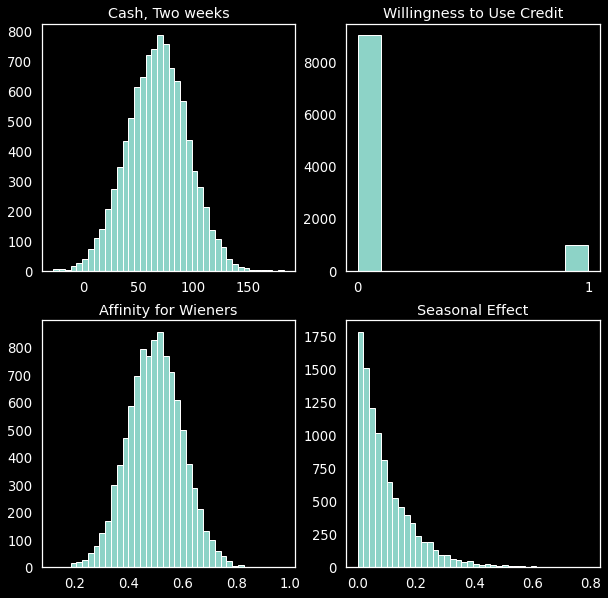

In [5]:
fig, axis = plt.subplots(nrows=2, ncols=2, figsize=(10,10))
axis[0,0].hist(customers.cash, bins=40)
axis[0,0].set_title('Cash, Two weeks')

axis[0,1].hist(customers.willingness, bins=10)
axis[0,1].set_title('Willingness to Use Credit')
axis[0,1].xaxis.set_ticks([0,1])

axis[1,0].hist(customers.affinity, bins=40)
axis[1,0].set_title('Affinity for Wieners')

axis[1,1].hist(customers.seasonality, bins=40)
axis[1,1].set_title('Seasonal Effect')
plt.show()

### Federal Holidays

No business will be conducted on these days

In [6]:
holidays = (date(2020, 1, 1), date(2020, 1, 20),
            date(2020, 2, 17),
            date(2020, 5, 25),
            date(2020, 7, 4),
            date(2020, 9, 7),
            date(2020, 11, 11), date(2020, 11, 26),
            date(2020, 12, 24), date(2020, 12, 25))

### Average Daily Customers

In 2019, Burger King had around 18,000 restaurant locations around the world, serving 11 million customers per day.  We will use this information for our average daily customer rate of = 612.

source: https://expandedramblings.com/index.php/burger-king-statistics-facts/

### Define Initial Parameters

* Date begins at Jan 1
* Start in Winter
* Include all customers (don't modify the original dataframe)
* Include holidays
* Real money spent begins at 0
* Rewards spent begins at 0
* Good experience rate 99.5%
* Customer reward rate 10%
* Customers can buy in discrete denominations of $8 - $32, counting by $4

In [56]:
params = Params(
    customers = customers,
    holidays = holidays,
    exp_rate = 0.995,
    reward_rate = 0.1,
    menu = (8, 12, 16, 20, 24, 28, 32),
    capacity = 612
    )

def make_system(params):
    """
    Make a system with the given parameters.
    Returns: System object.
    """
    init = State(
        customers = params.customers,
        day = date(2020, 1, 1),
        season = 'winter',
        buyers = None,
        history = pd.DataFrame(columns=[
            'day', 'customers', 'revenue', 'credit_issued',
            'credit_used', 'credit_traded'])
        )
    
    return System(params, state = init)

system = make_system(params)

### Start Day

* If the day is 1 or 15, wipe the cash, and refill the amount.
* Choose customers based on:
    * cash and credit available
    * affinity
    * seasonality
    * restaurant average daily numbers

In [48]:
def start_day(system):
    """
    Start a day in the system.
    Returns: System object.
    """
    
    # Potential customers are those who have cash or credit,
    # and who don't hate the restaurant.
    cash_buyers = system.state.customers[system.state.customers['cash'] >= 8]
    credit_buyers = system.state.customers[system.state.customers['credit'] >= 8]

    buyers = cash_buyers.merge(credit_buyers, how='outer')
    buyers = buyers[buyers['affinity'] > 0.05]

    # Customers are selected at random near the average daily total
    n = int(np.random.normal(loc=params.capacity, scale=20))
    system.state.buyers = buyers.sample(n)

    return system

### Conduct Business

* Selected customers make purchases
    * purchases are either cash or credit, not both
    * purchases are always in discrete amounts
* Rewards issued to "willing" customers
* Experience is good/bad
* History saved
    * number of customers
    * total purchases cash
    * total purchases credit
    * total credit issued

In [87]:
def conduct_business(system):
    """
    Makes sales for a day and issue credit accordingly.
    Returns: System object.
    """
    today = pd.Series(index=['day', 'customers', 'revenue', 
        'credit_issued', 'credit_used', 'credit_traded'])

    today['day'] = system.state.day
    today['customers'] = len(system.state.buyers)

    for i in system.state.buyers.index:
        # For each person, choose an item to buy.
        # If it is too expensive, the person buys the cheapest item.
        person = system.state.buyers.loc[i]
        print(person)
        
        item = np.random.choice(params.menu)
        if (item > person.cash) & (item > person.credit):
            item = 8

        # Buying with credit
        if (item <= person.credit):
            person.credit -= item
            today.credit_used += item

        # Buying with cash
        elif (item <= person.cash):
            person.cash -= item
            if person.willingness == 1:
                person.credit += item
                today.credit_issued += item
        
        # Punish negative dining experience, slightly reward a positive one
        if not flip(params.exp_rate):
            person.affinity /= 2
        else:
            person.affinity *= 1.05

    print(today)
    return system

In [88]:
sys = start_day(system)
sys = conduct_business(sys)
sys.state

/tmp/ipykernel_4778/1812978022.py:6: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  today = pd.Series(index=['day', 'customers', 'revenue',


salary         35085.660306
cash              67.472424
credit             0.000000
affinity           0.565485
seasonality        0.096724
willingness        0.000000
Name: 5695, dtype: float64
salary         33399.970874
cash              64.230713
credit             0.000000
affinity           0.736246
seasonality        0.003920
willingness        0.000000
Name: 263, dtype: float64
salary         34340.200410
cash              66.038847
credit             0.000000
affinity           0.612806
seasonality        0.743536
willingness        0.000000
Name: 5204, dtype: float64
salary         36702.138242
cash              70.581035
credit             0.000000
affinity           0.595094
seasonality        0.009896
willingness        0.000000
Name: 374, dtype: float64
salary         41228.948335
cash              79.286439
credit             0.000000
affinity           0.499362
seasonality        0.044061
willingness        0.000000
Name: 5804, dtype: float64
salary         63999.968436

,values
customers,salary cash credit affini...
day,2020-01-01
season,winter
buyers,salary cash credit affinit...
history,"Empty DataFrame Columns: [day, customers, reve..."


### After Hours Trading

* Trade or keep assets from the day, based on affinity score
* Trades subtract credit from Customer A
* Trades add 80% cash to Customer A
* Trades add credit to Customer B
* Trades subtract 80% cash from Customer B


In [10]:
def trade_rewards(system):
    """
    Dissatisfied customers trade credit for 80% cash.
    Returns: System object.
    """
    # For each dissatisfied customer, trade as much credit 
    # as possible to a random buyer.  If there is remaining
    # credit, find another random buyer.
    for i in system.state.customers[system.state.customers.affinity <= 0.05 \
        & system.state.customers.credit > 0].index:

        seller_index = system.state.customers.loc[i].index

        while system.state.customers.loc[i].credit > 0:

            # Find a random buyer
            buyer_index = system.state.customers[system.state.customers.affinity > 0.2 \
                & system.state.customers.cash > 8 * 0.8].sample(1).index

            # If the buyer has enough cash, trade it all
            if system.state.customers.iloc[buyer_index].credit > 0:
                system.state.customers.iloc[buyer_index].credit -= person.credit
                system.state.customers.iloc[seller_index].credit = 0

            # If the buyer doesn't have credit, trade as much as possible
            else:
                buyer.cash += person.credit
                person.credit = 0

            # Record the trade
            system.state.history.loc[-1, 'credit_traded'] += person.credit

    return(system)

### End Day

* If day is Dec 31, terminate simulation
* Start Spring Mar 20
* Start Summer Jun 21
* Start Autumn Sep 23
* Start Winter Dec 21

In [11]:
def end_day(system):
    """
    End a day in the system.
    Return: system object.
    """
    # Pay day!
    if system.day.day == (1 | 15):
        system.state.customers.cash = 0.05 * system.state.customers.salary / 26
    
    # Update season
    if system.state.day == date(2020, 3, 19):
        system.state.season = 'spring'
    elif system.state.day == date(2020, 6, 20):
        system.state.season = 'summer'
    elif system.state.day == date(2020, 9, 22):
        system.state.season = 'fall'
    elif system.state.day == date(2020, 12, 20):
        system.state.season = 'winter'
    
    # Update day
    system.state.day += timedelta(days=1)
    
    return system

### Run Simulation

* start_day()
* if day is holiday skip to end_day()
* conduct_business()
* after_hours()
* end_day()
* return system object

In [12]:
def run_simulation(system):
    """
    Run the simulation.
    Returns: System object.
    """
    while system.state.day < date(2020, 12, 31):
        system = start_day(system)

        # Nobody works on federal holidays!
        if system.state.day in system.params.holidays:
            system = end_day(system)

        # This is a normal day
        else:
            system = conduct_business(system)
            #system = trade_rewards(system)
            system = end_day(system)
            
    return system

In [15]:
final = run_simulation(system)

TypeError: Cannot perform 'ror_' with a dtyped [float64] array and scalar of type [bool]

### Cost/Benefit Analysis

Did customers eat more than they would have otherwise?

Did customers spend more than they would have otherwise?

What is the optimal reward rate?

### Descriptive Graphs

Total spent each day

Rewards used vs traded over all